### Step 37 텐서를 다루다
지금까지 구현한 함수들이 텐서도 잘 다룬다.


In [2]:
import numpy as np
import dezero.functions as F
from dezero import Variable

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sin(x)
print(y)

c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
print(x + c)

variable([[ 0.84147098  0.90929743  0.14112001]
          [-0.7568025  -0.95892427 -0.2794155 ]])
variable([[11 22 33]
          [44 55 66]])


In [3]:
t = x + c
y = F.sum(t)

y.backward(retain_grad=True)
print(y.grad)
print(t.grad)
print(x.grad)
print(c.grad)

variable(1)
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])


- 기울기의 형상과 데이터의 형상이 일치한다. (`x.shape == x.grad.shape`)
- 텐서의 미분을 머신러닝에서는 기울기(gradient)라고 한다.

#### 역전파 고찰
- $\bold{x,y}$ 벡터의 원소가 n개일 때, $\bold{y}=F(\bold{x})$의 미분 결과는 nxn 행렬이 된다. (야코비 행렬 Jacobian matrix)
- 자동 미분의 forward 모드를 수행하면 행렬 곱의 결과가 다시 행렬이 되는 것을 반복한다. (nxn 행렬을 전파한다)
- reverse 모드는 출력이 스칼라이므로 n개의 벡터를 전파한다.
- 그래서 역전파가 계산 효율이 더 좋다.

- 결과만 필요한 상황이라면 명시적으로 야코비 행렬을 구해서 행렬의 곱을 계산할 필요가 없다.
- 원소별 연산의 야코비 행렬은 대각 행렬이 된다. 최종 결과는 원소별 미분을 계산한 후 그 결과값을 원소별로 곱하면 얻을 수 있다.
- 원소별 연산에서는 역전파도 미분을 원소별로 곱하여 구한다.

### Step 38 형상 변환 함수
reshape, transpose

#### Reshape 함수 구현

In [4]:
import numpy as np
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.reshape(x, (6,))
print(y)

[1 2 3 4 5 6]


In [5]:
from dezero import Function

class Reshape(Function):
    def __init__(self, shape):
        self.shape = shape

    def forward(self, x):
        self.x_shape = x.shape
        y = x.reshape(self.shape)
        return y

    def backward(self, gy):
        return reshape(gy, self.x_shape)


from dezero.core import as_variable
def reshape(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return Reshape(shape)(x)

In [6]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.reshape(x, (6,))
y.backward(retain_grad=True)
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


In [7]:
import dezero
class Variable:
    # ...
    def reshape(self, *shape):
        if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
            shape = shape[0]

        # F.reshape가 아니라 아래처럼 쓴 이유: 순환 임포트를 피하기 위해서
        return dezero.functions.reshape(self, shape)

In [8]:
from dezero import Variable
x = Variable(np.random.randn(1, 2, 3))
y = x.reshape((2, 3))
print(y)
y = x.reshape(2, 3)
print(y)

variable([[-2.06150881  0.02763206  0.63438151]
          [ 0.88700969 -1.05686728  0.89565575]])
variable([[-2.06150881  0.02763206  0.63438151]
          [ 0.88700969 -1.05686728  0.89565575]])


#### Transpose

In [9]:
class Transpose(Function):
    def forward(self, x):
        y = np.transpose(x)
        return y

    def backward(self, gy):
        gx = transpose(gy)
        return gx

def transpose(x):
    return Transpose()(x)

In [10]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.transpose(x)
y.backward()
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


In [11]:
class Variable:
    # ...
    def transpose(self):
        # F.reshape가 아니라 아래처럼 쓴 이유: 순환 임포트를 피하기 위해서
        return dezero.functions.transpose(self)
    
    # 인스턴스 변수로 사용할 수 있도록!
    @property
    def T(self):
        return dezero.functions.transpose(self)

from dezero import Variable
x = Variable(np.random.randn(2, 3))
print(x)
y = x.transpose()
y = x.T
print(y)


variable([[-0.17898792 -0.7562412  -0.09146235]
          [ 0.53685879  0.14452229  1.44430452]])
variable([[-0.17898792  0.53685879]
          [-0.7562412   0.14452229]
          [-0.09146235  1.44430452]])


### Step 39 합계 함수

In [12]:
from dezero.functions import broadcast_to
class Sum(Function):
    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum()
        return y
    
    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum(x):
    return Sum()(x)

In [13]:
x = Variable(np.array([1, 2, 3, 4, 5, 6]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

variable(21)
variable([1 1 1 1 1 1])


In [14]:
# np.sum()
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.sum(x, axis=0)
print(y)
print(x.shape, ' -> ', y.shape)

[5 7 9]
(2, 3)  ->  (3,)


In [15]:
# np.sum()
x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.sum(x, keepdims=True)
print(y)
print(y.shape)

[[21]]
(1, 1)


In [16]:
from dezero.functions import broadcast_to
from dezero import utils

class Sum(Function):
    def __init__(self, axis, keepdims):
        self.axis = axis
        self.keepdims = keepdims

    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum(axis=self.axis, keepdims=self.keepdims)
        return y
    
    def backward(self, gy):
        gy = utils.reshape_sum_backward(gy, self.x_shape, self.axis, self.keepdims)
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum(x, axis=None, keepdims=False):
    return Sum(axis, keepdims)(x)

In [17]:
class Variable:
    #...
    def sum(self, axis=None, keepdims=False):
        return dezero.functions.sum(self, axis, keepdims)

In [18]:
# 사용 예
from dezero import Variable
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x, axis=0)
y.backward()
print(y)
print(x.grad)

x = Variable(np.random.randn(2, 3, 4, 5))
y = x.sum(keepdims=True)
print(y.shape)

variable([5 7 9])
variable([[1 1 1]
          [1 1 1]])
(1, 1, 1, 1)


### Step 40 브로드캐스트 함수
`broadcast_to`, `sum_to` 함수

In [19]:
# np.broadcast_to(x, shape)
x = np.array([1, 2, 3])
y = np.broadcast_to(x, (2, 3))
y

array([[1, 2, 3],
       [1, 2, 3]])

In [20]:
# sum_to
from dezero.utils import sum_to
x = np.array([[1, 2, 3], [4, 5, 6]])
y = sum_to(x, (1, 3))
print(y)

y = sum_to(x, (2, 1))
print(y)

[[5 7 9]]
[[ 6]
 [15]]


In [21]:
class BroadcastTo(Function):
    def __init__(self, shape):
        self.shape = shape
    
    def forward(self, x):
        self.x_shape = x.shape
        y = np.broadcast_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = sum_to(gy, self.x_shape)
        return gx

def broadcast_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return BroadcastTo(shape)(x)

In [22]:
class SumTo(Function):
    def __init__(self, shape):
        self.shape = shape

    def forward(self, x):
        self.x_shape = x.shape
        y = utils.sum_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return SumTo(shape)(x)

In [23]:
# Add 클래스 수정
class Add(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape #
        y = x0 + x1
        return y
    
    def backward(self, gy):
        gx0, gx1 = gy, gy
        if self.x0_shape != self.x1_shape: #
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape) #
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape) #
        return gx0, gx1

In [24]:
# 구현 확인
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

y.backward()
print(x1.grad)
print(x0.grad)

variable([11 12 13])
variable([3])
variable([1 1 1])


### Step 41 행렬의 곱

- 벡터의 내적: 두 벡터 사이의 대응 원소의 곱을 모두 합한 값
- 행렬의 곱: 왼쪽 행렬의 가로방향 벡터와 오른쪽 행렬의 세로방향 벡터 사이의 내적

In [25]:
# 벡터의 내적
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.dot(a, b)
print(c)

# 행렬의 곱
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
c = np.dot(a, b)
print(c)

32
[[19 22]
 [43 50]]


In [26]:
class MatMul(Function):
    def forward(self, x, W):
        y = x.dot(W)
        return y
    
    def backward(self, gy):
        x, W = self.inputs
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW

def matmul(x, W):
    return MatMul()(x, W)

In [27]:
x = Variable(np.random.randn(2, 3))
W = Variable(np.random.randn(3, 4))
y = F.matmul(x, W)
y.backward()

print(x.grad.shape)
print(W.grad.shape)

(2, 3)
(3, 4)


### Step 42 선형 회귀

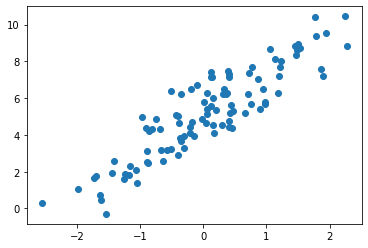

In [28]:
np.random.seed(0)
x = np.random.randn(100, 1)
y = 5 + 2 * x + np.random.randn(100, 1)

import matplotlib.pyplot as plt
plt.scatter(x, y)

In [29]:
x, y = Variable(x), Variable(y)

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x, W) + b
    return y

In [30]:
def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    print(W, b, loss)

variable([[0.49185321]]) variable([1.0403258]) variable(32.65684143290435)
variable([[0.87098307]]) variable([1.86670309]) variable(20.8049653938767)
variable([[1.16293087]]) variable([2.52326992]) variable(13.405480828635747)
variable([[1.38750254]]) variable([3.04503122]) variable(8.783241422956205)
variable([[1.56004728]]) variable([3.45975402]) variable(5.894230127462607)
variable([[1.69245272]]) variable([3.78946835]) variable(4.087467116592623)
variable([[1.79391933]]) variable([4.05165603]) variable(2.9568445746276204)
variable([[1.87156267]]) variable([4.26019247]) variable(2.248885834520452)
variable([[1.9308816]]) variable([4.42609289]) variable(1.8052961399692495)
variable([[1.97612211]]) variable([4.55810367]) variable(1.5271664114616335)
variable([[2.01055989]]) variable([4.66317115]) variable(1.352658545853154)
variable([[2.0367197]]) variable([4.7468132]) variable(1.2430881436096468)
variable([[2.05654553]]) variable([4.81341393]) variable(1.1742401964288234)
variable([[

In [31]:
class MeanSquaredError(Function):
    def forward(self, x0, x1):
        diff = x0 - x1
        y = (diff ** 2).sum() / len(diff)
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs
        diff = x0 - x1
        gx0 = gy * diff * (2. / len(diff))
        gx1 = -gx0
        return gx0, gx1

def mean_squared_error(x0, x1):
    return MeanSquaredError()(x0, x1)

### Step 43 신경망

- Linear transformation == Affine transformation:
    
    $y = xW$

In [32]:
def linear_simple(x, W, b=None):
    t = matmul(x, W)
    if b is None:
        return t
    
    y = t + b
    t.data = None
    return y

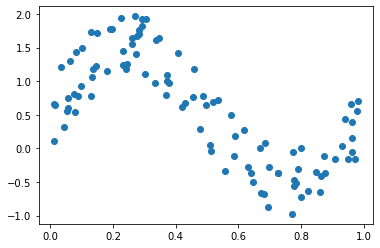

In [33]:
# 비선형 데이터셋
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

plt.scatter(x, y)

In [34]:
def sigmoid_simple(x):
    x = as_variable(x)
    y = 1 / (1 + exp(-x))
    return y

신경망 구현 예
```
def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y
```

In [35]:
# 실제 데이터셋으로 신경망 학습 예제
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# 가중치 초기화
I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

# 신경망 추론
def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

lr = 0.2
iters = 10000

# 신경망 학습
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    if i % 1000 == 0:
        print(loss)

variable(0.8473695850105871)
variable(0.2514286285183607)
variable(0.2475948546674987)
variable(0.23786120447054812)
variable(0.21222231333102934)
variable(0.16742181117834157)
variable(0.09681932619992645)
variable(0.0784952829060233)
variable(0.07749729552991157)
variable(0.07722132399559316)


### Step 44 매개변수를 모아두는 계층

In [36]:
class Parameter(Variable):
    pass

In [37]:
# Variable과 기능은 같지만 구별할 수 있다.
x = Variable(np.array(1.0))
p = Parameter(np.array(2.0))
y = x * p

print(isinstance(p, Parameter))
print(isinstance(x, Parameter))
print(isinstance(y, Parameter))

True
False
False


In [38]:
# Layer 클래스 구현
class Layer:
    def __init__(self):
        # Layer 클래스가 갖는 매개변수를 인스턴스 변수 _params에 모아둘 수 있다.
        self._params = set()
    
    def __setattr__(self, name, value):
        if isinstance(value, Parameter):
            self._params.add(name)
        super().__setattr__(name, value)

In [39]:
layer = Layer()

layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Variable(np.array(3))
layer.p4 = 'test'

print(layer._params)
print('-----------')

for name in layer._params:
    print(name, layer.__dict__[name])

{'p2', 'p1'}
-----------
p2 variable(2)
p1 variable(1)


In [40]:
import weakref

class Layer:
    def __init__(self):
        # Layer 클래스가 갖는 매개변수를 인스턴스 변수 _params에 모아둘 수 있다.
        self._params = set()
    
    def __setattr__(self, name, value):
        if isinstance(value, Parameter):
            self._params.add(name)
        super().__setattr__(name, value)

    def __call__(self, *inputs):
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs,)
        self.inputs = [weakref.ref(x) for x in inputs]
        self.outputs = [weakref.ref(y) for x in outputs]
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, inputs):
        raise NotImplementedError()
    
    def params(self):
        for name in self._params:
            yield self.__dict__[name]
        
    def cleargrads(self):
        for param in self.params():
            param.cleargrad()

In [41]:
class Linear(Layer):
    def __init__(self, in_size, out_size, nobias=False, dtype=np.float32):
        super().__init__()

        I, O = in_size, out_size
        W_data = np.random.randn(I, O).astype(dtype) * np.sqrt(1 / I)
        self.W = Parameter(W_data, name='W')
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(0, dtype=dtype), name='b')
    
    def forward(self, x):
        y = F.linear(x, self.W, self.b)
        return y

In [42]:
# 개선된 버전
class Linear(Layer):
    def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.dtype = dtype

        self.W = Parameter(None, name='W')
        if self.in_size is not None:
            self._init_W()
        
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')
    
    def _init_W(self):
        I, O = self.in_size, self.out_size
        W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I)
        self.W.data = W_data

    def forward(self, x):
        # 데이터를 흘려보내는 시점에 가중치 초기화
        if self.W.data is None:
            self.in_size = x.shape[1]
            self._init_W()

        y = F.linear(x, self.W, self.b)
        return y

In [43]:
import dezero.layers as L

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10)
l2 = L.Linear(1)

def predict(x):
    y = l1(x)
    y = F.sigmoid(y)
    y = l2(y)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)
    l1.cleargrads()
    l2.cleargrads()
    loss.backward()

    for l in [l1, l2]:
        for p in l.params():
            # print(p.data)
            p.data -= lr * p.grad.data
    
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649356)
variable(0.07888166506355153)
variable(0.07655073683421637)
variable(0.07637803086238228)
variable(0.07618764131185567)


### Step 45 계층을 모아두는 계층

Layer 안에 다른 Layer가 들어갈 수 있도록

In [44]:
class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)): # Layer 추가
            self._params.add(name)
        super().__setattr__(name, value)
    
    def params(self):
        for name in self._params:
            obj = self.__dict__[name]

            if isinstance(obj, Layer): # Layer에서 매개변수 꺼내기
                yield from obj.params() #
            else:
                yield obj

In [45]:
from dezero.layers import Layer

model = Layer()
model.l1 = L.Linear(5)
model.l2 = L.Linear(3)

def predict(model, x):
    y = model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y

for p in model.params():
    print(p)

model.cleargrads()

variable(None)
variable([0. 0. 0.])
variable(None)
variable([0. 0. 0. 0. 0.])


In [46]:
# Layer 클래스 상속하여 모델 전체를 하나의 클래스로 정의
class TwoLayerNet(Layer):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
    
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

Model 클래스 정의

모델이란? '사물의 본질을 단순하게 표현한 것'

머신러닝 모델 또한 '복잡한 패턴이나 규칙이 숨어 있는 현상을 수식으로 단순하게 표현한 것'이다. 신경망처럼 수식으로 표현할 수 있는 함수를 가리켜 모델이라고 한다.

In [47]:
class Model(Layer):
    def plot(self, *inputs, to_file='model.png'):
        y = self.forward(*inputs)
        return utils.plot_dot_graph(y, verbose=True, to_file=to_file)

In [48]:
# TwoLayerNet with Model class
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)

In [49]:
# Model을 사용한 sin 함수 데이터셋 회귀
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
    
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y
    
model = TwoLayerNet(hidden_size, 1)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    for p in model.params():
        p.data -= lr * p.grad.data
    
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649356)
variable(0.07888166506355153)
variable(0.07655073683421637)
variable(0.07637803086238228)
variable(0.07618764131185567)


In [50]:
# MLP 클래스
class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid):
        super().__init__()
        self.activation = activation
        self.layers = []

        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer)
            self.layers.append(layer)
    
    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        return self.layers[-1](x)

### Step 46 Optimizer로 수행하는 매개변수 갱신

경사하강법 외에 다양한 최적화 기법 구현을 위한 Optimizer 클래스

In [51]:
class Optimizer:
    def __init__(self):
        self.target = None
        self.hooks = []
    
    def setup(self, target):
        self.target = target
        return self
    
    def update(self):
        # None 이외의 매개변수를 리스트에 모아둠
        params = [p for p in self.target.params() if p.grad is not None]
        
        # 전처리 (옵션)
        for f in self.hooks:
            f(params)

        # 매개변수 갱신
        for param in params:
            self.update_one(param)
        
    def update_one(self, param):
        raise NotImplementedError()

    def add_hook(self, f):
        self.hooks.append(f)

In [52]:
# SGD 클래스
class SGD(Optimizer):
    def __init__(self, lr=0.01):
        super().__init__()
        self.lr = lr
    
    def update_one(self, param):
        param.data -= self.lr * param.grad.data

In [53]:
# SGD 클래스 활용
from dezero import optimizers

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

model = MLP((hidden_size, 1))
# optimizer = optimizers.SGD(lr)
# optimizer.setup(model)
optimizer = optimizers.SGD(lr).setup(model)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    optimizer.update() #
    if i % 1000 == 0:
        print(loss)


variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649356)
variable(0.07888166506355153)
variable(0.07655073683421637)
variable(0.07637803086238228)
variable(0.07618764131185567)


In [54]:
for name in model._params:
    print(name, model.__dict__[name].W)

# type(model.__dict__['l1'])

# model.params().

print('------')

for p in model.params():
    print(p.name, p.data)

l0 variable([[ 1.6524137  -2.1517513  -9.170103   -1.1727254  -1.1385859   3.307915
            1.617087   -0.63725543 -2.1345348   1.4791305 ]])
l1 variable([[ 1.0825084 ]
          [-2.7484486 ]
          [ 5.4915586 ]
          [-1.3048114 ]
          [-1.197905  ]
          [ 0.32324767]
          [ 1.4315618 ]
          [-0.86709327]
          [-2.6347868 ]
          [ 1.2583766 ]])
------
W [[ 1.6524137  -2.1517513  -9.170103   -1.1727254  -1.1385859   3.307915
   1.617087   -0.63725543 -2.1345348   1.4791305 ]]
b [-0.9606268   0.49943432  4.5593724   0.16067517  0.20714144 -1.874649
 -0.5832339  -0.00763051  0.57859486 -0.5276554 ]
W [[ 1.0825084 ]
 [-2.7484486 ]
 [ 5.4915586 ]
 [-1.3048114 ]
 [-1.197905  ]
 [ 0.32324767]
 [ 1.4315618 ]
 [-0.86709327]
 [-2.6347868 ]
 [ 1.2583766 ]]
b [-0.91091275]


In [55]:
# MomentumSGD
class MomentumSGD(Optimizer):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.vs = {}

    def update_one(self, param):
        v_key = id(param)
        if v_key not in self.vs:
            self.vs[v_key] = np.zeros_like(param.data)
        
        v = self.vs[v_key]
        v *= self.momentum
        v -= self.lr * param.grad.data
        param.data += v

### Step 47 소프트맥스 함수와 교차 엔트로피 오차

In [56]:
# 슬라이스
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
indices = np.array([0, 0, 1])
y = F.get_item(x, indices)
print(y)

variable([[1 2 3]
          [1 2 3]
          [4 5 6]])


In [57]:
import dezero.functions as F
Variable.__getitem__ = F.get_item
y = x[1]
print(y)

y = x[:, 2]
print(y)

variable([4 5 6])
variable([3 6])


In [58]:
# Softmax
def softmax1d(x):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y / sum_y

In [62]:
model = MLP((10, 3))

x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax1d(y)

print(y)
print(p)

variable([[0.25337848 0.30853735 0.38821423]])
variable([[0.31239678 0.33011233 0.35749089]])


In [66]:
# 배치 데이터 처리 가능한 softmax 함수
from dezero.functions import *
def softmax_simple(x, axis=1):
    x = as_variable(x)
    y = exp(x)
    sum_y = sum(y, axis=axis, keepdims=True)
    return y / sum_y

In [71]:
# 교차 엔트로피 함수 구현
def softmax_cross_entropy_simple(x, t):
    x, t = as_variable(x), as_variable(t)
    N = x.shape[0]

    p = softmax_simple(x)
    p = clip(p, 1e-15, 1.0)
    log_p = log(p)
    tlog_p = log_p[np.arange(N), t.data]
    y = -1 * sum(tlog_p) / N
    return y

In [73]:
# 교차 엔트로피 함수 활용
x = np.array([[0.2, -0.4], [0.3, 0.5], [1.3, -3.2], [2.1, 0.3]])
t = np.array([2, 0, 1, 0])
y = model(x)
loss = F.softmax_cross_entropy(y, t)
print(loss)

variable(1.1784240941964543)


### Step 48 다중 클래스 분류

(300, 2)
(300,)
[-0.12995958 -0.00324155] 1
[ 0.3282343  -0.54941994] 0


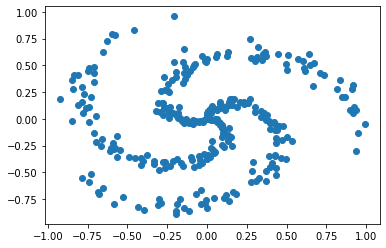

In [83]:
x, t = dezero.datasets.get_spiral(train=True)
print(x.shape)
print(t.shape)

print(x[10], t[10])
print(x[110], t[110])
plt.scatter(x[:, 0], x[:, 1])

In [87]:
# 다중 분류 학습
import math

# 하이퍼파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

# 데이터 읽기 / 모델, 옵티마이저 생성
x, t = dezero.datasets.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(x)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    # 데이터셋의 인덱스 뒤섞기
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # 미니 배치 생성
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]

        # 기울기 산출 / 매개변수 갱신
        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(batch_t)

    # 에포크마다 학습 경과 출력
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch+1, avg_loss))

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

### Step 49 Dataset 클래스와 전처리

In [89]:
class Dataset:
    def __init__(self, train=True):
        self.train = train
        self.data = None
        self.label = None
        self.prepare()

    def __getitem__(self, index):
        assert np.isscalar(index) # index는 정수(스칼라)만 지원
        if self.label is None:
            return self.data[index], None
        else:
            return self.data[index], self.label[index]
        
    def __len__(self):
        return len(self.data)
    
    def prepare(self):
        pass

In [91]:
from dezero.datasets import get_spiral
class Spiral(Dataset):
    def prepare(self):
        self.data, self.label = get_spiral(self.train)

In [92]:
train_set = dezero.datasets.Spiral(train=True)
print(train_set[0])
print(len(train_set))

(array([-0.13981389, -0.00721657], dtype=float32), 1)
300


In [93]:
# 큰 데이터셋
class BigData(Dataset):
    def __getitem__(index):
        x = np.load('data/{}.npy'.format(index))
        t = np.load('label/{}.npy'.format(index))
        return x, t
    
    def __len__():
        return 1000000

In [94]:
# 데이터 이어붙이기
train_set = dezero.datasets.Spiral()

batch_index = [0, 1, 2]
batch = [train_set[i] for i in batch_index]

x = np.array([example[0] for example in batch])
t = np.array([example[1] for example in batch])

print(x.shape)
print(t.shape)

(3, 2)
(3,)


In [96]:
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral()
model = MLP((hidden_size, 10))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # 미니배치 꺼내기
        batch_index = index[i * batch_size:(i+1) * batch_size]
        batch = [train_set[i] for i in batch_index]
        batch_x = np.array([example[0] for example in batch])
        batch_t = np.array([example[1] for example in batch])

        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)
    
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))


epoch 1, loss 1.35
epoch 2, loss 1.06
epoch 3, loss 0.98
epoch 4, loss 0.90
epoch 5, loss 0.88
epoch 6, loss 0.84
epoch 7, loss 0.84
epoch 8, loss 0.81
epoch 9, loss 0.79
epoch 10, loss 0.77
epoch 11, loss 0.80
epoch 12, loss 0.77
epoch 13, loss 0.76
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.76
epoch 17, loss 0.76
epoch 18, loss 0.80
epoch 19, loss 0.78
epoch 20, loss 0.77
epoch 21, loss 0.76
epoch 22, loss 0.74
epoch 23, loss 0.79
epoch 24, loss 0.77
epoch 25, loss 0.75
epoch 26, loss 0.77
epoch 27, loss 0.77
epoch 28, loss 0.74
epoch 29, loss 0.77
epoch 30, loss 0.75
epoch 31, loss 0.75
epoch 32, loss 0.77
epoch 33, loss 0.74
epoch 34, loss 0.75
epoch 35, loss 0.76
epoch 36, loss 0.74
epoch 37, loss 0.80
epoch 38, loss 0.73
epoch 39, loss 0.74
epoch 40, loss 0.74
epoch 41, loss 0.78
epoch 42, loss 0.75
epoch 43, loss 0.72
epoch 44, loss 0.74
epoch 45, loss 0.71
epoch 46, loss 0.72
epoch 47, loss 0.74
epoch 48, loss 0.71
epoch 49, loss 0.71
epoch 50, loss 0.71
epoch 51,

In [97]:
# 데이터셋 전처리 (ex. Data augmentation)
class Dataset:
    def __init__(self, train=True, transform=None, target_transform=None):
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        if self.transform is None:
            self.transform = lambda x: x
        if self.target_transform is None:
            self.target_transform = lambda x: x
        
        self.data = None
        self.label = None
        self.prepare()
    
    def __getitem__(self, index):
        assert np.isscalar(index)
        if self.label is None:
            return self.transform(self.data[index]), None
        else:
            return self.transform(self.data[index]), \
                   self.target_transform(self.label[index])
    
    def __len__(self):
        return len(self.data)
    
    def prepare(self):
        pass

In [98]:
def f(x):
    y = x / 2.0
    return y

train_set = dezero.datasets.Spiral(transform=f)

In [102]:
from dezero import transforms

f = transforms.Normalize(mean=0.0, std=2.0)
train_set = dezero.datasets.Spiral(transform=f)

f = transforms.Compose([transforms.Normalize(mean=0.0, std=2.0),
                        transforms.AsType(np.float64)])

### Step 50 미니배치를 뽑아주는 DataLoader

In [104]:
# 반복자(iterator)
t = [1, 2, 3]
x = iter(t)
print(next(x))
print(next(x))
print(next(x))
print(next(x))

1
2
3


StopIteration: 

In [105]:
class MyIterator:
    def __init__(self, max_cnt):
        self.max_cnt = max_cnt
        self.cnt = 0

    def __iter__(self):
        return self
    
    def __next__(self):
        if self.cnt == self.max_cnt:
            raise StopIteration()
        
        self.cnt += 1
        return self.cnt

In [106]:
obj = MyIterator(5)
for x in obj:
    print(x)

1
2
3
4
5


In [108]:
class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(dataset)
        self.max_iter = math.ceil(self.data_size / batch_size)

        self.reset()
    
    def reset(self):
        self.iteration = 0  # 반복 횟수 초기화
        if self.shuffle:
            self.index = np.random.permutation(len(self.dataset))
        else:
            self.index = np.arange(len(self.dataset))
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration
    
        i, batch_size = self.iteration, self.batch_size
        batch_index = self.index[i * batch_size:(i + 1) * batch_size]
        batch = [self.dataset[i] for i in batch_index]
        x = np.array([example[0] for example in batch])
        t = np.array([example[1] for example in batch])

        self.iteration += 1
        return x, t
    
    def next(self):
        return self.__next__()

In [110]:
# DataLoader 사용
from dezero.datasets import Spiral
from dezero import DataLoader

batch_size = 10
max_epoch = 1

train_set = Spiral(train=True)
test_set = Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(max_epoch):
    for x, t in train_loader:
        print(x.shape, t.shape)
        break

    for x, t in test_loader:
        print(x.shape, t.shape)
        break

(10, 2) (10,)
(10, 2) (10,)


In [111]:
# accuracy 함수
def accuracy(y, t):
    y, t = as_variable(y), as_variable(t)

    pred = y.data.argmax(axis=1).reshape(t.shape)
    result = (pred == t.data)
    acc = result.mean()
    return Variable(as_array(acc))

In [112]:
# accuracy 함수 활용
y = np.array([[0.2, 0.8, 0], [0.1, 0.9, 0], [0.8, 0.1, 0.1]])
t = np.array([1, 2, 0])
acc = F.accuracy(y, t)
print(acc)

variable(0.6666666666666666)


In [114]:
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral(train=True)
test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss / len(train_set),
        sum_acc / len(train_set)))
    
    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)
        
    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)
    ))

epoch: 1
train loss: 1.0944, accuracy: 0.4033
test loss: 1.0468, accuracy: 0.3267
epoch: 2
train loss: 0.9882, accuracy: 0.4933
test loss: 0.9729, accuracy: 0.4333
epoch: 3
train loss: 0.9403, accuracy: 0.5133
test loss: 0.8965, accuracy: 0.6233
epoch: 4
train loss: 0.8820, accuracy: 0.5700
test loss: 0.8771, accuracy: 0.5967
epoch: 5
train loss: 0.8617, accuracy: 0.5600
test loss: 0.8670, accuracy: 0.5867
epoch: 6
train loss: 0.8313, accuracy: 0.5300
test loss: 0.8654, accuracy: 0.6000
epoch: 7
train loss: 0.8086, accuracy: 0.5833
test loss: 0.7950, accuracy: 0.5600
epoch: 8
train loss: 0.7948, accuracy: 0.5733
test loss: 0.7921, accuracy: 0.5900
epoch: 9
train loss: 0.7728, accuracy: 0.5500
test loss: 0.7718, accuracy: 0.5300
epoch: 10
train loss: 0.7643, accuracy: 0.5633
test loss: 0.7796, accuracy: 0.5800
epoch: 11
train loss: 0.7862, accuracy: 0.5600
test loss: 0.7701, accuracy: 0.5633
epoch: 12
train loss: 0.7914, accuracy: 0.5500
test loss: 0.8218, accuracy: 0.6067
epoch: 13
tra

### Step 51 MNIST 학습

In [116]:
train_set = dezero.datasets.MNIST(train=True, transform=None)
test_set = dezero.datasets.MNIST(train=False, transform=None)

print(len(train_set))
print(len(test_set))

Downloading: train-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: train-labels-idx1-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-labels-idx1-ubyte.gz
[##############################] 100.00% Done
60000
10000


In [117]:
x, t = train_set[0]
print(type(x), x.shape)
print(t)

<class 'numpy.ndarray'> (1, 28, 28)
5


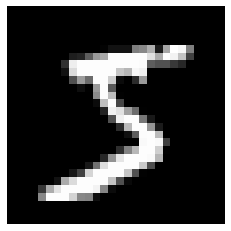

label: 5


In [118]:
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print('label:', t)

In [119]:
# 데이터 전처리
def f(x):
    x = x.flatten()
    x = x.astype(np.float32)
    x /= 255.0
    return x

train_set = dezero.datasets.MNIST(train=True, transform=f)
test_set = dezero.datasets.MNIST(train=False, transform=f)

In [122]:
# 학습
max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)
    ))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)
    
    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)
    ))

epoch: 1
train loss: 1.9158, accuracy: 0.5507
test loss: 1.5420, accuracy: 0.7191
epoch: 2
train loss: 1.2851, accuracy: 0.7709
test loss: 1.0428, accuracy: 0.8168
epoch: 3
train loss: 0.9253, accuracy: 0.8191
test loss: 0.7925, accuracy: 0.8351
epoch: 4
train loss: 0.7405, accuracy: 0.8404
test loss: 0.6570, accuracy: 0.8573
epoch: 5
train loss: 0.6355, accuracy: 0.8533
test loss: 0.5767, accuracy: 0.8692


In [123]:
# ReLU
class ReLU(Function):
    def forward(self, x):
        y = np.maximum(x, 0.0)
        return y
    
    def backward(self, gy):
        x, = self.inputs
        mask = x.data > 0
        gx = gy * mask
        return gx
    
def relu(x):
    return ReLU()(x)

In [125]:
model = MLP((hidden_size, hidden_size, 10), activation=F.relu)

In [126]:
# 학습 (ReLU 사용)
max_epoch = 5
batch_size = 100
hidden_size = 1000

optimizer = optimizers.SGD().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)
    ))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t) 
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)
    
    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)
    ))

epoch: 1
train loss: 1.0708, accuracy: 0.7749
test loss: 0.4797, accuracy: 0.8872
epoch: 2
train loss: 0.4185, accuracy: 0.8900
test loss: 0.3455, accuracy: 0.9081
epoch: 3
train loss: 0.3383, accuracy: 0.9063
test loss: 0.3013, accuracy: 0.9172
epoch: 4
train loss: 0.3014, accuracy: 0.9155
test loss: 0.2753, accuracy: 0.9244
epoch: 5
train loss: 0.2770, accuracy: 0.9222
test loss: 0.2562, accuracy: 0.9297
